## Importing the Dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

In [13]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

## Loading and having a look at the data

In [2]:
train = pd.read_csv('D://College//Northeastern_DS//DS_5500_Capstone//Data_set//train_file//train.csv')

C:\Users\prati\AppData\Local\Temp\ipykernel_36996\2406092770.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('D://College//Northeastern_DS//DS_5500_Capstone//Data_set//train_file//train.csv')


In [3]:
train.head()

MachineIdentifier   ProductName EngineVersion  \
0  0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1  000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2  000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3  00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4  000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1735.0       0               7.0                 0   
1     4.13.17134.1    1.263.48.0       0               7.0                 0   
2  4.18.1807.18075  1.273.1341.0       0               7.0                 0   
3  4.18.1807.18075  1.273.1527.0       0               7.0                 0   
4  4.18.1807.18075  1.273.1379.0       0               7.0                 0   

   DefaultBrowsersIdentifier  AVProductStatesIdentifier  ...  \
0                        NaN                    53447.0  ...   
1                        NaN                    53447.0  ...   
2                        NaN                    53447.0  ...   
3                        NaN                    53447.0  ...   
4                        NaN                    53447.0  ...   

   Census_FirmwareVersionIdentifier  Census_IsSecureBootEnabled  \
0                           36144.0                           0   
1                           57858.0                           0   
2                           52682.0                           0   
3                           20050.0                           0   
4                           19844.0                           0   

   Census_IsWIMBootEnabled  Census_IsVirtualDevice  Census_IsTouchEnabled  \
0                      NaN                     0.0                      0   
1                      NaN                     0.0                      0   
2                      NaN                     0.0                      0   
3                      NaN                     0.0                      0   
4                      0.0                     0.0                      0   

   Census_IsPenCapable  Census_IsAlwaysOnAlwaysConnectedCapable  Wdft_IsGamer  \
0                    0                                      0.0           0.0   
1                    0                                      0.0           0.0   
2                    0                                      0.0           0.0   
3                    0                                      0.0           0.0   
4                    0                                      0.0           0.0   

  Wdft_RegionIdentifier HasDetections  
0                  10.0             0  
1                   8.0             0  
2                   3.0             0  
3                   3.0             1  
4                   1.0             1  

[5 rows x 83 columns]

In [4]:
train.shape

(8921483, 83)

In [3]:
# setting the Machine ID as the index

train.set_index("MachineIdentifier", inplace=True)

In [4]:
# finding out the amount of null values

train.isnull().sum()

ProductName                                     0
EngineVersion                                   0
AppVersion                                      0
AvSigVersion                                    0
IsBeta                                          0
                                            ...  
Census_IsPenCapable                             0
Census_IsAlwaysOnAlwaysConnectedCapable     71343
Wdft_IsGamer                               303451
Wdft_RegionIdentifier                      303451
HasDetections                                   0
Length: 82, dtype: int64

As the next step of preprocessing, we are going to divide the columns in columns containing numerical features,
columns containing binary features and finally, columns containing categorical features

In [7]:
total_features = train.columns
numerical_features = list(train._get_numeric_data().columns)
binary_features = []
categorical_features = list(set(total_features) - set(numerical_features))
for i in numerical_features:
    if (train[str(i)].min() == 0 and train[str(i)].max() == 1) and train[str(i)].min()== 0:
        binary_features.append(i)
numerical_features = list(set(numerical_features)- set(binary_features))
print("The total number of categorical features in the dataset: " + str(len(categorical_features)))
print("The total number of numerical features in the dataset: " + str(len(numerical_features)))
print("The total number of binary features in the dataset: " + str(len(binary_features)))

The total number of categorical features in the dataset: 29
The total number of numerical features in the dataset: 33
The total number of binary features in the dataset: 20


Checking the statistics of the dataset

In [8]:
statistics = []
for col in train.columns:
    statistics.append((
        col, train[col].nunique(), 
        train[col].isnull().sum() * 100 / train.shape[0],  
        train[col].dtype
    ))
    
stats = pd.DataFrame(statistics, columns=['Feature', 'Type',  'Percentage of missing values', 'Unique_values',])
stats.sort_values('Percentage of missing values', ascending=False)

Feature  Type  Percentage of missing values  \
27                     PuaMode     2                     99.974119   
40       Census_ProcessorClass     3                     99.589407   
7    DefaultBrowsersIdentifier  2017                     95.141637   
67  Census_IsFlightingInternal     2                     83.044030   
51  Census_InternalBatteryType    78                     71.046809   
..                         ...   ...                           ...   
1                EngineVersion    70                      0.000000   
44  Census_HasOpticalDiskDrive     2                      0.000000   
53            Census_OSVersion   469                      0.000000   
54       Census_OSArchitecture     3                      0.000000   
81               HasDetections     2                      0.000000   

   Unique_values  
27        object  
40        object  
7        float64  
67       float64  
51        object  
..           ...  
1         object  
44         int64  
53        object  
54        object  
81         int64  

[82 rows x 4 columns]

Finding out features that are too skewed

In [9]:
pd.options.display.float_format = '{:,.4f}'.format
skewed = pd.DataFrame([{'column': c, 'uniq': train[c].nunique(), 'skewed': train[c].value_counts(normalize=True).values[0] * 100} for c in train.columns])
skewed = skewed.sort_values('skewed', ascending=False)
skewed

column    uniq   skewed
74           Census_IsWIMBootEnabled       2 100.0000
4                             IsBeta       2  99.9992
68          Census_IsFlightsDisabled       2  99.9990
67        Census_IsFlightingInternal       2  99.9986
26                   AutoSampleOptIn       2  99.9971
..                               ...     ...      ...
39   Census_ProcessorModelIdentifier    3428   3.2576
3                       AvSigVersion    8531   1.1469
13                    CityIdentifier  107366   1.1030
72  Census_FirmwareVersionIdentifier   50494   1.0228
43  Census_SystemVolumeTotalCapacity  536848   0.5863

[82 rows x 3 columns]

There are 12 categorical columns whos are too skewed and that is why they are not needed because,
they are useless too.

### Missing values

In [10]:
train.DefaultBrowsersIdentifier.value_counts().head(5)

239.0000      46056
3,195.0000    42692
1,632.0000    28751
3,176.0000    24220
146.0000      20756
Name: DefaultBrowsersIdentifier, dtype: int64

In [11]:
train.DefaultBrowsersIdentifier.fillna(0, inplace=True)

In [12]:
train.SmartScreen.value_counts()

RequireAdmin    4316183
ExistsNotSet    1046183
Off              186553
Warn             135483
Prompt            34533
Block             22533
off                1350
On                  731
&#x02;              416
&#x01;              335
on                  147
requireadmin         10
OFF                   4
0                     3
Promt                 2
Enabled               1
prompt                1
warn                  1
00000000              1
requireAdmin          1
&#x03;                1
Name: SmartScreen, dtype: int64

In [5]:
smart_screen_values = {'off': 'Off', 'requireadmin': 'RequireAdmin',  
                       'requireAdmin': 'RequireAdmin', 'warn': 'Warn',  np.nan: 'NoExist'}
train.replace({'SmartScreen': smart_screen_values}, inplace=True)

In [6]:
train.SmartScreen.isnull().sum()

0

In [15]:
# 'OrganizationIdentifier' column has ids and 0 can represent unknown values.

train.replace({'OrganizationIdentifier': {np.nan: 0}}, inplace=True)

In [16]:
train.Census_InternalBatteryType.value_counts()

lion    2028256
li-i     245617
#        183998
lip       62099
liio      32635
         ...   
˙˙˙          1
lgl0          1
l            1
@i          1
lÿÿÿ          1
Name: Census_InternalBatteryType, Length: 78, dtype: int64

In [17]:
# checking the percentage of missing values in column "Census_InternalBatteryType"

train.Census_InternalBatteryType.isna().sum()/train.shape[0]

0.7104680914596823

"Census_InternalBatteryType" column  has more than 70 percent of missing values as well as "unkn" values which seem to mean "unknown". So we are going to replace these values with "unknown"

In [7]:
battery_values = { 'unkn': 'unknown', np.nan: 'unknown'}
train.replace({'Census_InternalBatteryType': battery_values}, inplace=True)

###  Label Encoding 

In [8]:
train['SmartScreen'] = train.SmartScreen.astype('category')
train['Census_InternalBatteryType'] = train.Census_InternalBatteryType.astype('category')

categories = train.select_dtypes(include='category').columns.tolist()
le = LabelEncoder()

for col in categories:
    train[col] = le.fit_transform(train[col])

### Plotting Correlation Heatmaps

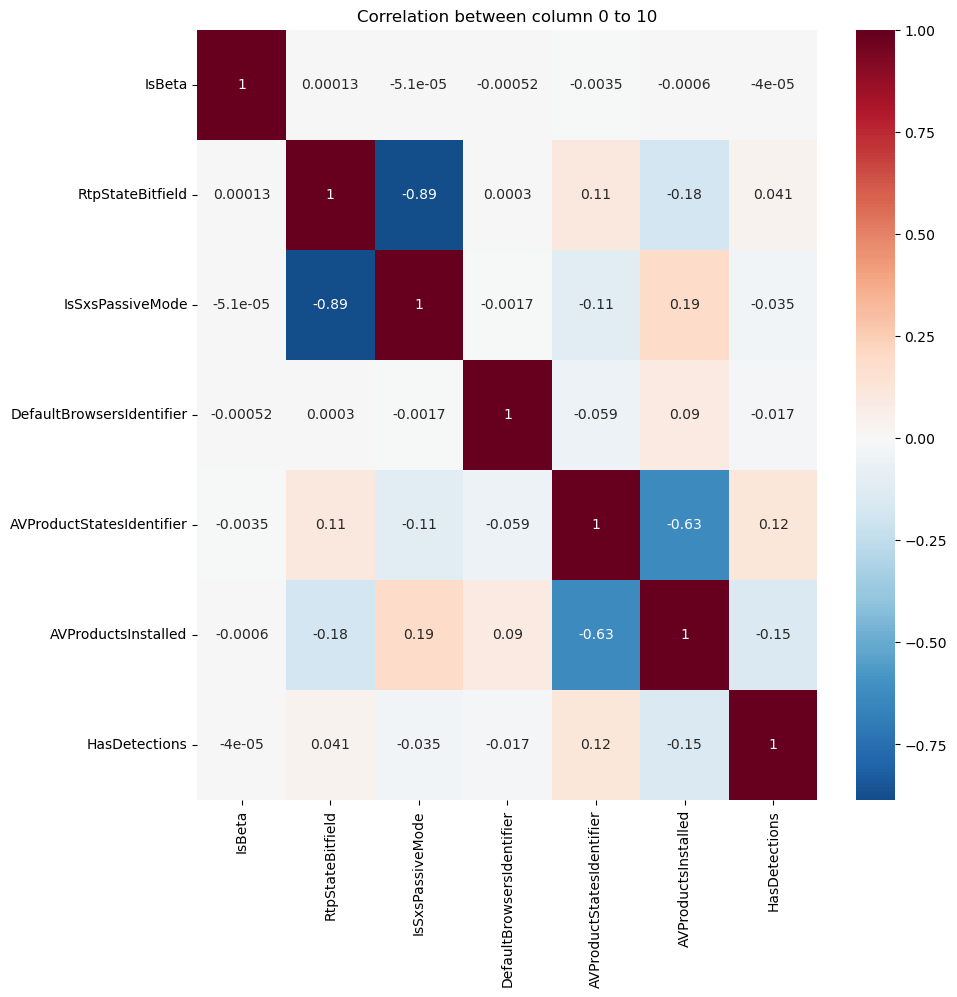

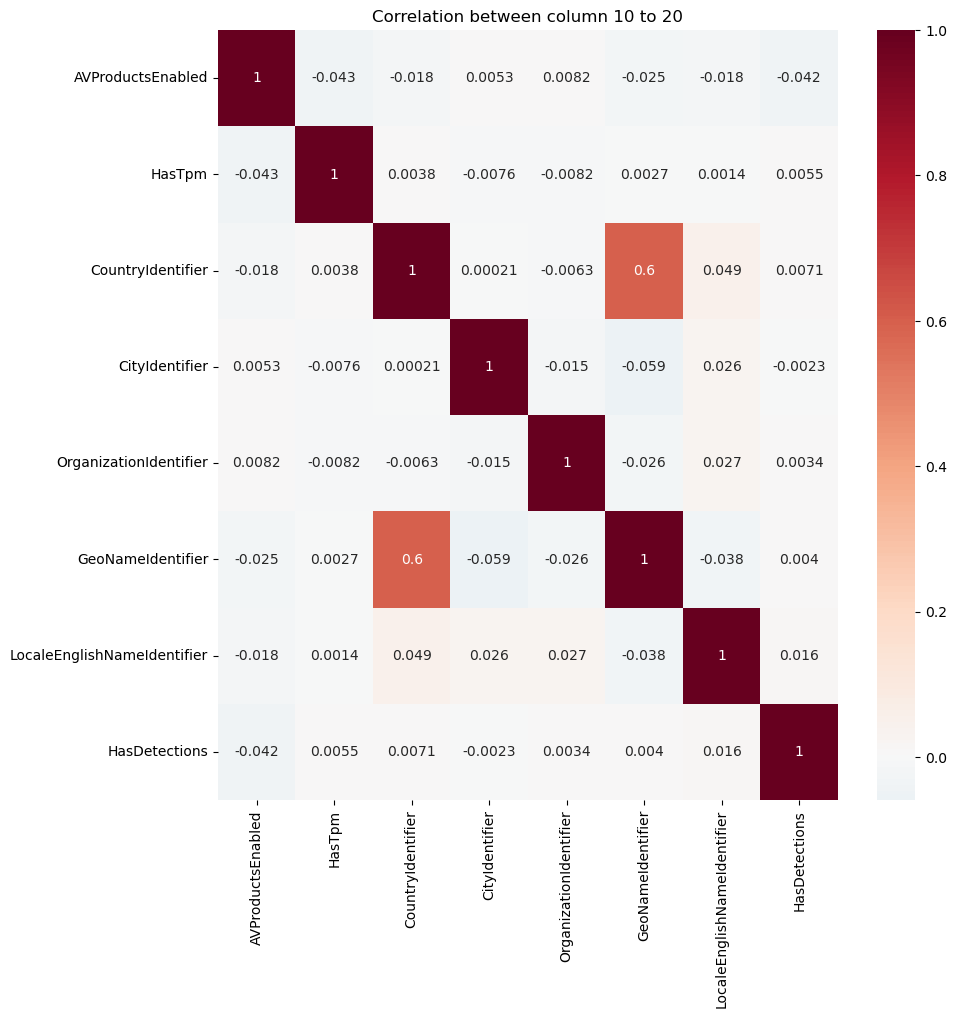

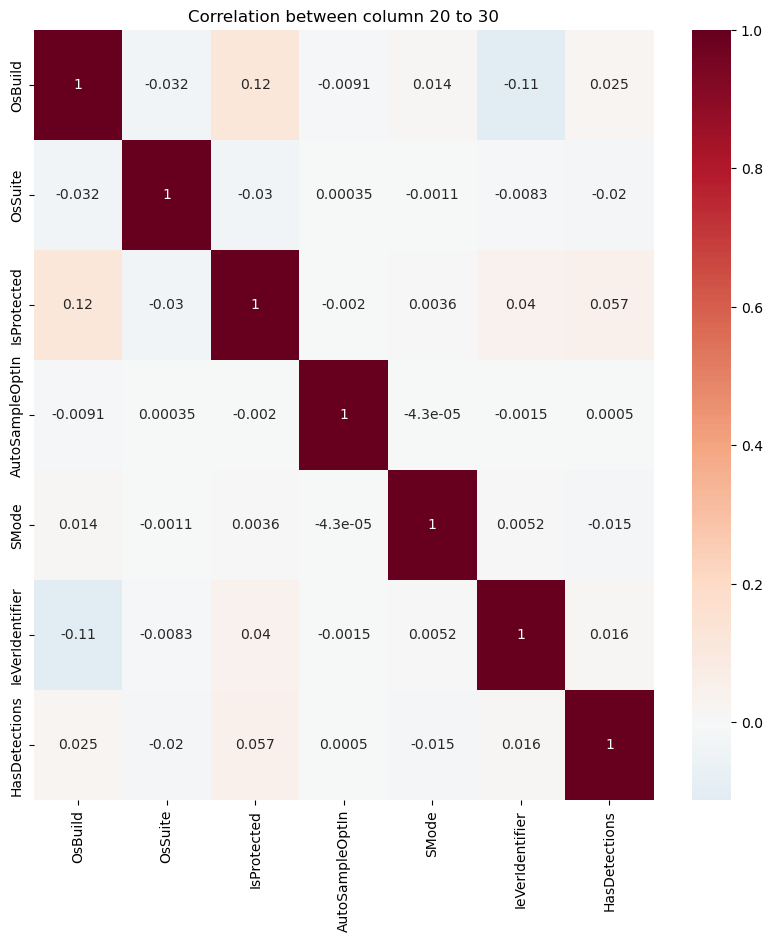

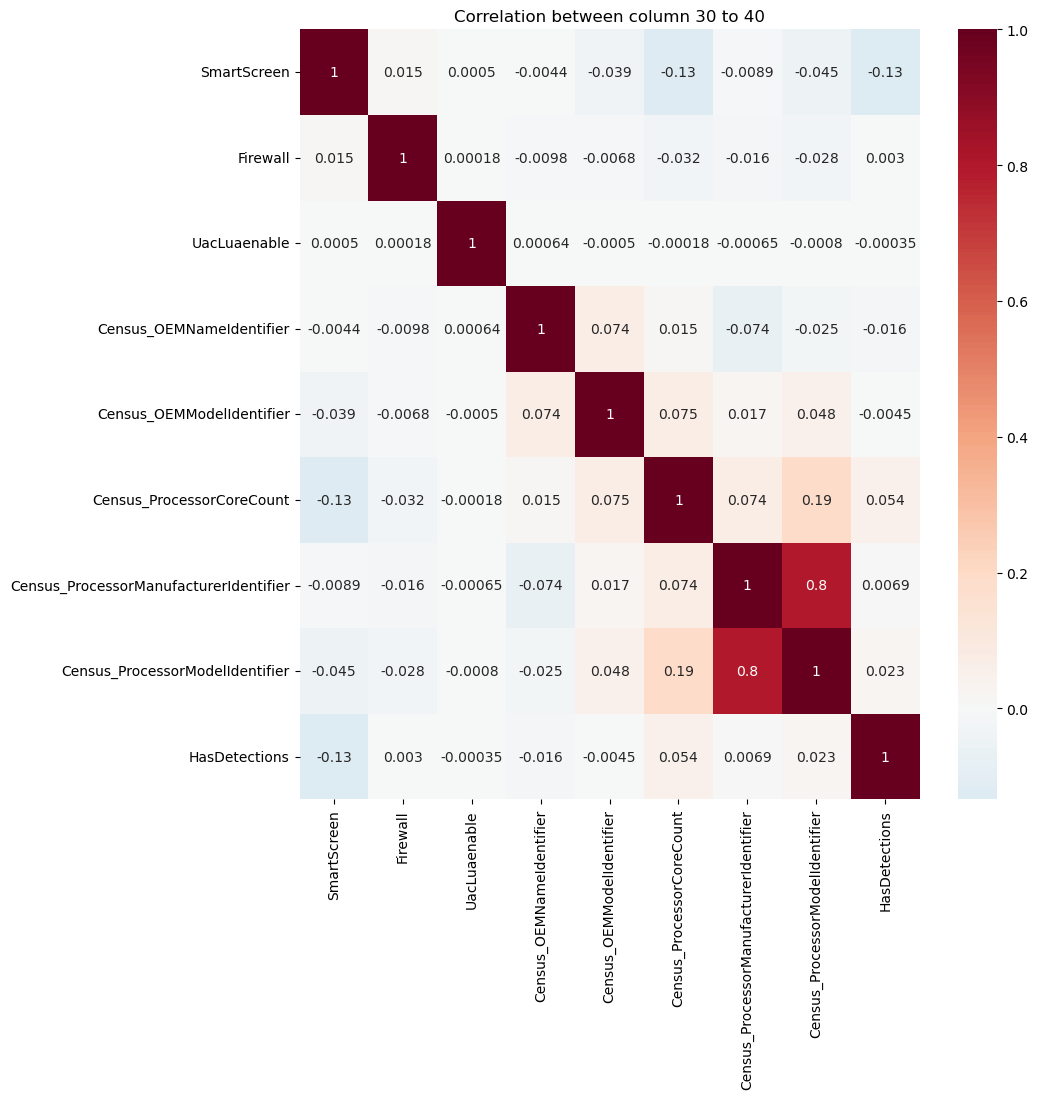

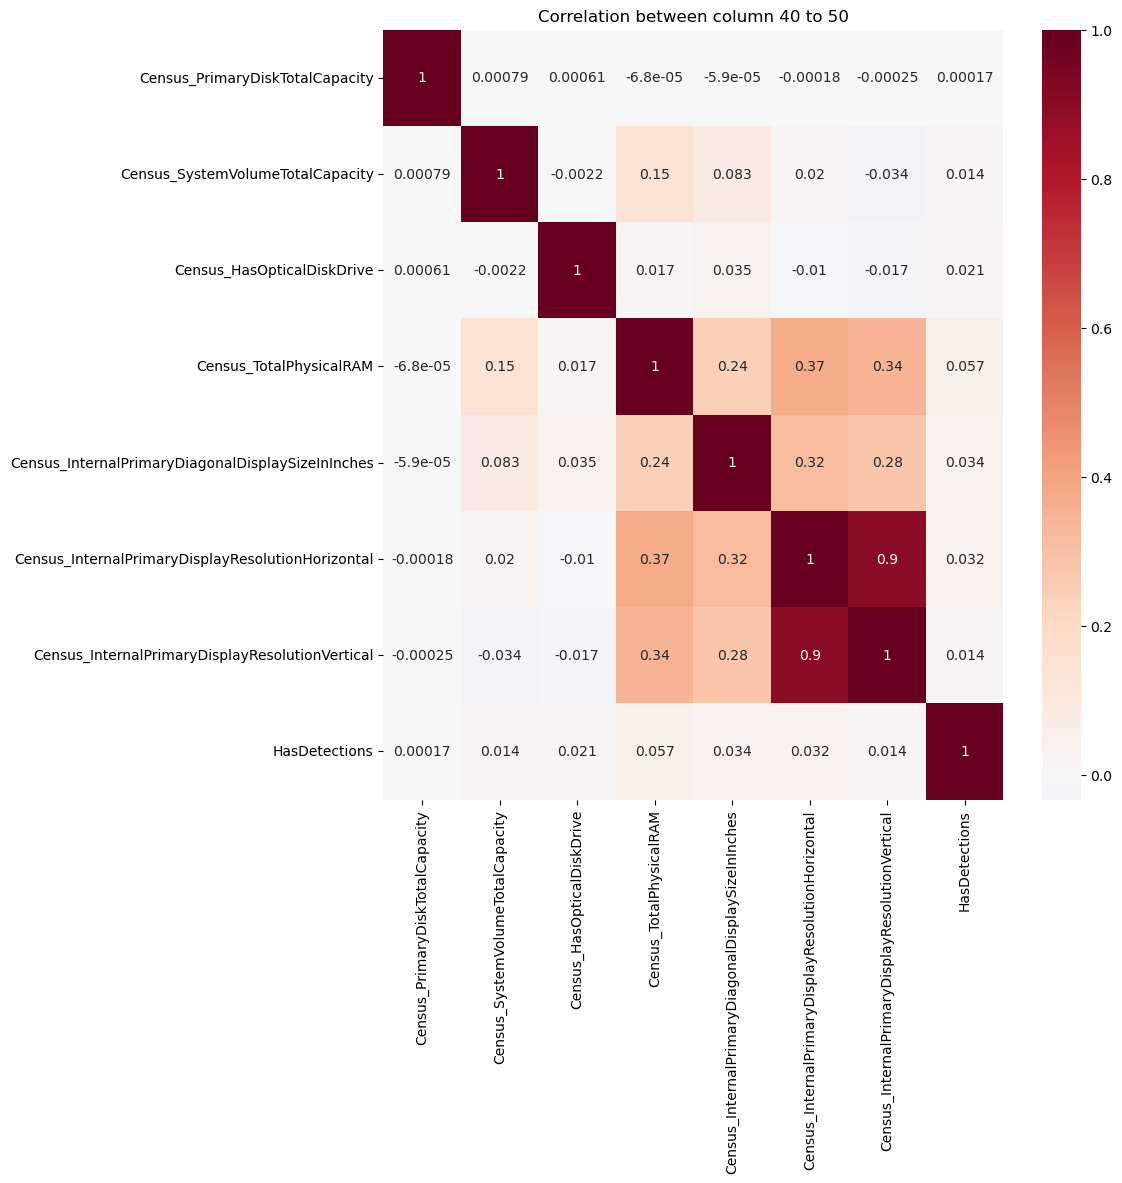

In [20]:
## correlation between features
for i in range(1,6):
    cols = train.columns.tolist()
    plt.figure(figsize=(10,10))
    co_cols = cols[(i-1)*10:i*10]
    co_cols.append('HasDetections')
    sns.heatmap(train[co_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    plt.title("Correlation between column " + str(10*(i-1)) + " to " + str(10*i))
    plt.show()

From the above heatmaps we can drop the following columns:
1. Platform
2. Census_OSSkuName
3. Census_OSInstallLanguageIdentifier

Based on the above analysis of heatmaps and the too skewed plu missing values
we are removing these columns because of the following reasons:
1. mostly missing values
2. very skewed features
3. hugely correlated features

In [1]:
removable_columns = ['IsBeta','Census_IsFlightsDisabled','AutoSampleOptIn','SMode',
                     'Census_IsPortableOperatingSystem','Census_DeviceFamily','UacLuaenable',
                     'Census_IsVirtualDevice','Platform','Census_OSSkuName']

train.drop(removable_columns, axis=1, inplace=True)

NameError: name 'train' is not defined

## EDA 

In [22]:
def operate_EDA(train_data) :

    '''Generating SNS Plot for has_detection column'''
    ax = sns.countplot(x="HasDetections", data=train_data,palette = "Paired")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01))
    plt.show()

    '''Generating SNS Plot for Processor column'''
    ax = sns.countplot(x="Processor", data=train_data,palette = "Paired")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01))
    plt.show()

    '''Generating SNS Plot for OsVer column'''
    t = pd.DataFrame(train_data.value_counts('OsVer')[:10])
    t = t.reset_index()
    t = t.rename(columns={0: "Values"})
    # p = t.plot(kind='bar', title='Count for Top 10 OS Version')

    ax = sns.barplot(x="OsVer",y = 'Values' ,data=t,palette = "Paired")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01))
    plt.show()


    '''Generating SNS Plot for IsProtected column'''
    ax = sns.countplot(x="IsProtected", data=train_data,palette = "Paired")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01))
    plt.show()

    '''Generating SNS Plot for Firewall column'''
    ax = sns.countplot(x="Firewall", data=train_data,palette = "Paired")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01))
    plt.show()

    '''Generating a SNS plot combined for Firewall and HasDetections'''
    ax = sns.countplot(x="Firewall", hue='HasDetections', data=train_data, palette="Paired")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01))
    plt.show()

    '''Generating a SNS plot combined for IsProtected and HasDetections'''
    ax = sns.countplot(x="IsProtected", hue='HasDetections', data=train_data, palette="Paired")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01))
    plt.show()

    '''Generating a SNS plot combined for IsProtected and HasDetections'''
    ax = sns.countplot(x="Processor", hue='HasDetections', data=train_data, palette="Paired")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01))
    plt.show()

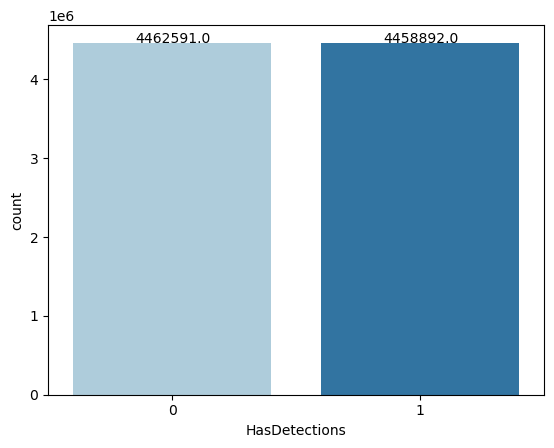

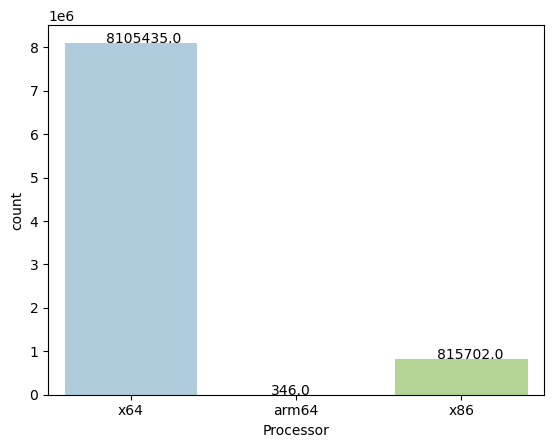

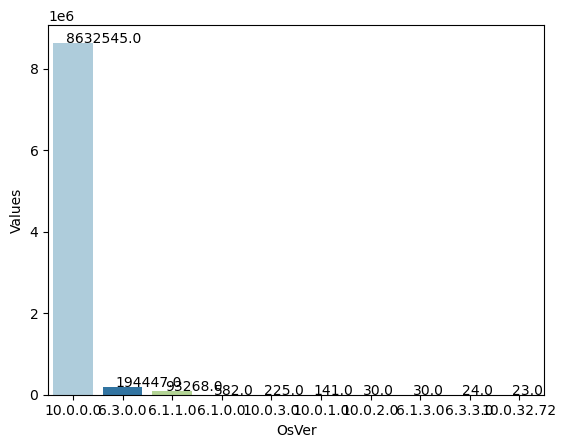

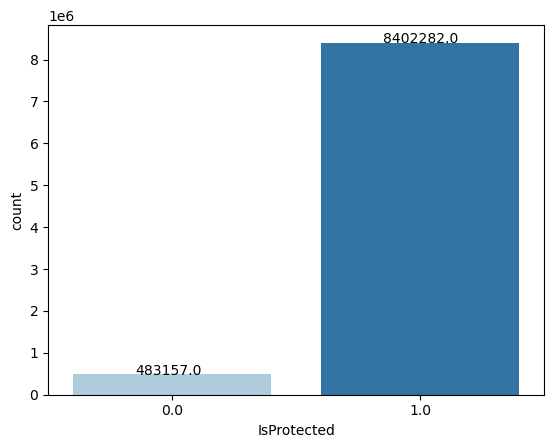

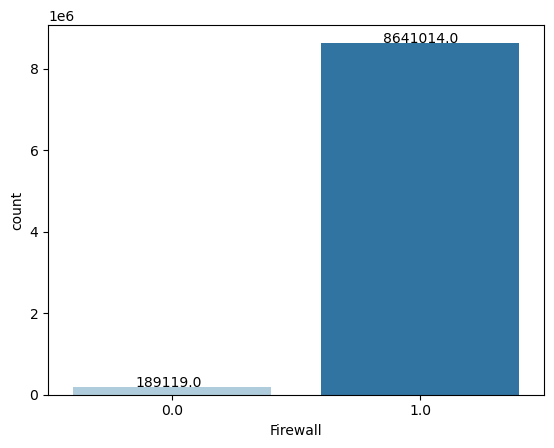

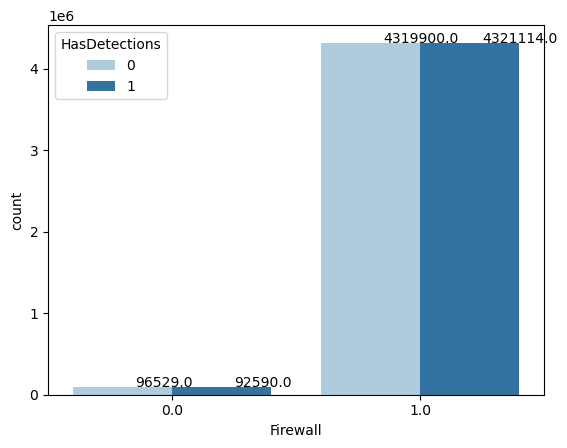

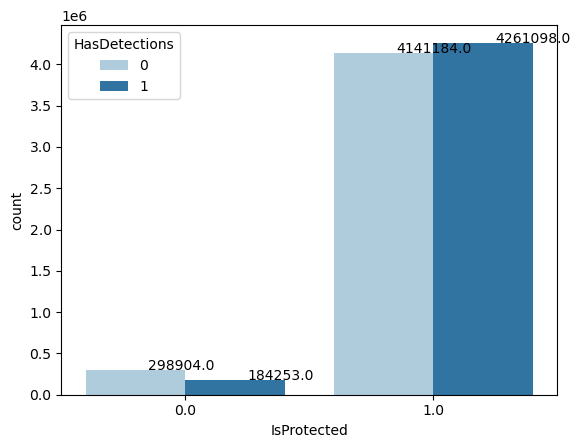

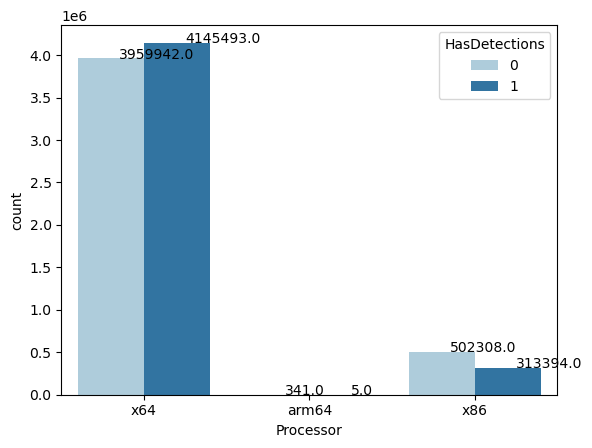

In [23]:
operate_EDA(train)

In [24]:
## separating target variable and training variables

target = train['HasDetections']
del train['HasDetections']
train.shape

(8921483, 65)

### Imputing the missing values

#### Since there is a memory constriaint we are sub-setting the dataset

In [25]:
train2 = train[:50000]
target2 = target[:50000]

In [26]:

X = pd.get_dummies(train2)

my_imputer = SimpleImputer()
X = my_imputer.fit_transform(X)

X.shape

(50000, 3964)

### Feature selection

We are using Extra Tress Classifier to find out the best features for proceeding with the model training

In [27]:
classifier = ExtraTreesClassifier(n_estimators=5)
classifier = classifier.fit(X, target2)
classifier.feature_importances_  

model = SelectFromModel(classifier, prefit=True)
train_new = model.transform(X)
train_new.shape  

(50000, 406)

In [39]:
train_1 = train[:10000]

In [36]:
train_1 = train_1.select_dtypes(['int8','int16','float16','float32'])

In [41]:
train_1 = pd.get_dummies(train_1,columns=train_1.columns.tolist())

In [42]:
train_1.head(2)

ProductName_mse  ProductName_win8defender  \
MachineIdentifier                                                             
0000028988387b115f69f31a3bf04f09                0                         1   
000007535c3f730efa9ea0b7ef1bd645                0                         1   

                                  EngineVersion_1.1.12805.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          0   

                                  EngineVersion_1.1.12902.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          0   

                                  EngineVersion_1.1.13000.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          0   

                                  EngineVersion_1.1.13103.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          0   

                                  EngineVersion_1.1.13202.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          0   

                                  EngineVersion_1.1.13303.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          0   

                                  EngineVersion_1.1.13407.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          0   

                                  EngineVersion_1.1.13504.0  ...  \
MachineIdentifier                                            ...   
0000028988387b115f69f31a3bf04f09                          0  ...   
000007535c3f730efa9ea0b7ef1bd645                          0  ...   

                                  Wdft_RegionIdentifier_8.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          1   

                                  Wdft_RegionIdentifier_9.0  \
MachineIdentifier                                             
0000028988387b115f69f31a3bf04f09                          0   
000007535c3f730efa9ea0b7ef1bd645                          0   

                                  Wdft_RegionIdentifier_10.0  \
MachineIdentifier                                              
0000028988387b115f69f31a3bf04f09                           1   
000007535c3f730efa9ea0b7ef1bd645                           0   

                                  Wdft_RegionIdentifier_11.0  \
MachineIdentifier                                              
0000028988387b115f69f31a3bf04f09                           0   
000007535c3f730efa9ea0b7ef1bd645                           0   

                                  Wdft_RegionIdentifier_12.0  \
MachineIdentifier                                              
0000028988387b115f69f31a3bf04f09                           0   
000007535c3f730efa9ea0b7ef1bd645                           0   

                                  Wdft_RegionIdentifier_13.0  \
MachineIdentifier                                              
0000028988387b115f69f31a3bf04f09                           0   
000007535c3f730efa9ea0b7ef1bd645                           0   

                                  Wdft_RegionIdentifier_14.0  \
MachineIdentifier                                              
00000289883

In [46]:
import re
train_1 = train_1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [44]:
features = list(train_1.columns)

lgb_params = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 42,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=10, shuffle=True, random_state=42)
oof_lgb = np.zeros(len(train_1))

In [ ]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_1.values, target_1.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_1.iloc[trn_idx][features], label=target_1.iloc[trn_idx])
    val_data = lgb.Dataset(train_1.iloc[val_idx][features], label=target_1.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=150)